<p style="font-family: Helvetica, Arial, sans-serif; font-weight: bold; font-size: 30px; color: #003366;">
Airlines Review Analysis

<p style="font-family: Helvetica, Arial, sans-serif; font-size: 16px; color: #003366;">
This notebook presents an Exploratory Data Analysis (EDA) of an airline review dataset. The aim is to explore customer satisfaction and identify the factors that significantly influence airline ratings.

<p style="font-family: Helvetica, Arial, sans-serif; font-weight: bold; font-size: 16px; color: #003366"><br/>
    Importing  necessary libraries and dataset

In [208]:
import pandas as pd
import re
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import requests
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [209]:
dataset_path = 'airline reviews_countries updated.csv'
df = pd.read_csv(dataset_path)
df.head()

,Overall_Rating,Unnamed,Airline Name,Review_Title,Review Date,Verified,Review,Aircraft,Type Of Traveller,Seat Type,...,Country of Arrival,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money,Recommended
0,9,0,AB Aviation,"""pretty decent airline""",11th November 2019,True,Moroni to Moheli. Turned out to be a pretty de...,NaN,Solo Leisure,Economy Class,...,Comoro Islands,November 2019,4.0,5.0,4.0,4.0,NaN,NaN,3.0,yes
1,1,1,AB Aviation,"""Not a good airline""",25th June 2019,True,Moroni to Anjouan. It is a very small airline....,E120,Solo Leisure,Economy Class,...,Comoro Islands,June 2019,2.0,2.0,1.0,1.0,NaN,NaN,2.0,no
2,1,2,AB Aviation,"""flight was fortunately short""",25th June 2019,True,Anjouan to Dzaoudzi. A very small airline and ...,Embraer E120,Solo Leisure,Economy Class,...,Mayotte,June 2019,2.0,1.0,1.0,1.0,NaN,NaN,2.0,no
3,1,3,Adria Airways,"""I will never fly again with Adria""",28th September 2019,False,Please do a favor yourself and do not fly with...,NaN,Solo Leisure,Economy Class,...,Kosovo,September 2019,1.0,1.0,NaN,1.0,NaN,NaN,1.0,no
4,1,4,Adria Airways,"""it ruined our last days of holidays""",24th September 2019,True,Do not book a flight with this airline! My fri...,NaN,Couple Leisure,Economy Class,...,Netherlands,September 2019,1.0,1.0,1.0,1.0,1.0,1.0,1.0,no


<p style="font-family: Helvetica, Arial, sans-serif; font-weight: bold; font-size: 16px; color: #003366"><br/>
    Get a summary of the data

In [210]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23171 entries, 0 to 23170
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Overall_Rating          23171 non-null  object 
 1   Unnamed                 23171 non-null  int64  
 2   Airline Name            23171 non-null  object 
 3   Review_Title            23171 non-null  object 
 4   Review Date             23171 non-null  object 
 5   Verified                23171 non-null  bool   
 6   Review                  23171 non-null  object 
 7   Aircraft                7108 non-null   object 
 8   Type Of Traveller       19433 non-null  object 
 9   Seat Type               22075 non-null  object 
 10  Route                   19343 non-null  object 
 11  Departure               23171 non-null  object 
 12  Arrival                 23171 non-null  object 
 13  Country of Departure    23171 non-null  object 
 14  Country of Arrival      23171 non-null

In [211]:
df.shape

(23171, 24)

<p style="font-family: Helvetica, Arial, sans-serif; font-weight: bold; font-size: 16px; color: #003366"><br/>
Data cleaning

In [212]:
# checking for duplicates
duplicates = df.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

df[duplicates]

Number of duplicate rows: 0


,Overall_Rating,Unnamed,Airline Name,Review_Title,Review Date,Verified,Review,Aircraft,Type Of Traveller,Seat Type,...,Country of Arrival,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money,Recommended


In [213]:
# dropping columns that will not be utilised
df.drop(['Overall_Rating', 'Departure', 'Arrival', 'Route'], axis=1, inplace=True)

In [214]:
# checking for null values
df.isnull().sum()

Unnamed                       0
Airline Name                  0
Review_Title                  0
Review Date                   0
Verified                      0
Review                        0
Aircraft                  16063
Type Of Traveller          3738
Seat Type                  1096
Country of Departure          0
Country of Arrival            0
Date Flown                 3754
Seat Comfort               4155
Cabin Staff Service        4260
Food & Beverages           8671
Ground Service             4793
Inflight Entertainment    12342
Wifi & Connectivity       17251
Value For Money            1066
Recommended                   0
dtype: int64

In [215]:
# filling in missing values for categorical columns

mode_type_of_traveller = df['Type Of Traveller'].mode()[0]
df['Type Of Traveller'].fillna(mode_type_of_traveller, inplace=True)

mode_seat_type = df['Seat Type'].mode()[0]
df['Seat Type'].fillna(mode_seat_type, inplace=True)

numerical_columns = df.select_dtypes(include=['float64']).columns

# filling in missing values for numerical columns

for column in numerical_columns:
    group_means = df.groupby('Airline Name')[column].transform('mean')
    group_means.fillna(df[column].mean(), inplace=True)
    df[column] = df[column].fillna(group_means).round(0).astype(float)
    
# filling in missing values for Date Flown using backward fill method

df['Date Flown'] = df.groupby('Airline Name')['Date Flown'].fillna(method='ffill')
df['Date Flown'] = df.groupby('Airline Name')['Date Flown'].fillna(method='bfill')

df.isnull().sum()

Unnamed                       0
Airline Name                  0
Review_Title                  0
Review Date                   0
Verified                      0
Review                        0
Aircraft                  16063
Type Of Traveller             0
Seat Type                     0
Country of Departure          0
Country of Arrival            0
Date Flown                  310
Seat Comfort                  0
Cabin Staff Service           0
Food & Beverages              0
Ground Service                0
Inflight Entertainment        0
Wifi & Connectivity           0
Value For Money               0
Recommended                   0
dtype: int64

In [216]:
# re-adding the previously dropped ‘Route’ column, this time using concatenation of Country of Departure and Country of Arrival

df['Route'] = df['Country of Departure'] + ' to ' + df['Country of Arrival']

In [217]:
# re-adding the previously dropped ‘Overall Ratings’ column, this time by calculating it as the sum of the Service Category ratings

df['Overall Rating'] = df[['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 'Ground Service', 'Inflight Entertainment', 'Wifi & Connectivity', 'Value For Money']].sum(axis=1)
df.head(2)

,Unnamed,Airline Name,Review_Title,Review Date,Verified,Review,Aircraft,Type Of Traveller,Seat Type,Country of Departure,...,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money,Recommended,Route,Overall Rating
0,0,AB Aviation,"""pretty decent airline""",11th November 2019,True,Moroni to Moheli. Turned out to be a pretty de...,NaN,Solo Leisure,Economy Class,Comoro Islands,...,4.0,5.0,4.0,4.0,2.0,2.0,3.0,yes,Comoro Islands to Comoro Islands,24.0
1,1,AB Aviation,"""Not a good airline""",25th June 2019,True,Moroni to Anjouan. It is a very small airline....,E120,Solo Leisure,Economy Class,Comoro Islands,...,2.0,2.0,1.0,1.0,2.0,2.0,2.0,no,Comoro Islands to Comoro Islands,12.0


<p style="font-family: Helvetica, Arial, sans-serif; font-weight: bold; font-size: 16px; color: #003366"><br/>
    Which airlines receive the highest and lowest ratings, in terms of average overall ratings?

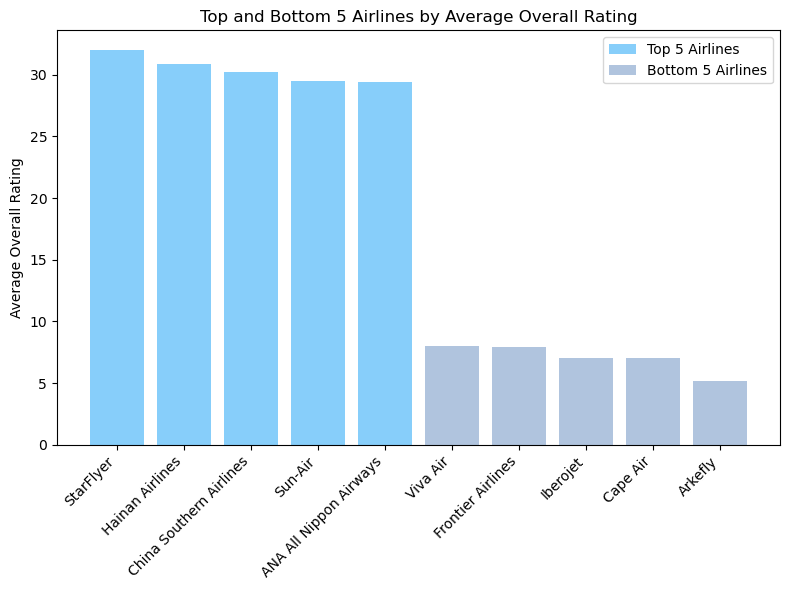

In [218]:
# calculate the mean overall rating, grouped by airline name 
airline_ratings = df.groupby('Airline Name')['Overall Rating'].mean().reset_index().round(1)
airline_ratings = airline_ratings.sort_values(by='Overall Rating', ascending=False)

# get top and bottom 5 airlines
top_5_airlines = airline_ratings.head(5).copy()
bottom_5_airlines = airline_ratings.tail(5).copy()

plt.figure(figsize=(8, 6))

# bar chart for top 5 airlines
plt.bar(top_5_airlines['Airline Name'], top_5_airlines['Overall Rating'], color='#87CEFA', label="Top 5 Airlines")

# bar chart for bottom 5 airlines
plt.bar(bottom_5_airlines['Airline Name'], bottom_5_airlines['Overall Rating'], color='#B0C4DE', label="Bottom 5 Airlines")

# label and title
plt.title("Top and Bottom 5 Airlines by Average Overall Rating")
plt.ylabel("Average Overall Rating")
plt.legend()
plt.xticks(rotation=45, ha='right') 
plt.tight_layout() 

plt.show()

<p style="font-family: Helvetica, Arial, sans-serif; font-weight: regular; font-size: 16px; color: #003366;">
    The above analysis shows a clear distinction between the top 5 and bottom 5 airlines based on average of the numerical ratings. The top 5 airlines exhibit significantly higher average rating, with ratings in the range of 29 to 30, compared to the bottom 5 with ratings from 5 to 8. <br/>

<p style="font-family: Helvetica, Arial, sans-serif; font-weight: bold; font-size: 16px; color: #003366"><br/>
    What are the common review and sentiments in passenger reviews for the top and bottom airline?
<p style="font-family: Helvetica, Arial, sans-serif; font-weight: regular; font-size: 16px; color: #003366">
    The following uses wordcloud text analysis to determine the frequent words used in the review for the top and bottom airline. This will give us a clearer picture of what’s driving those high or low ratings.

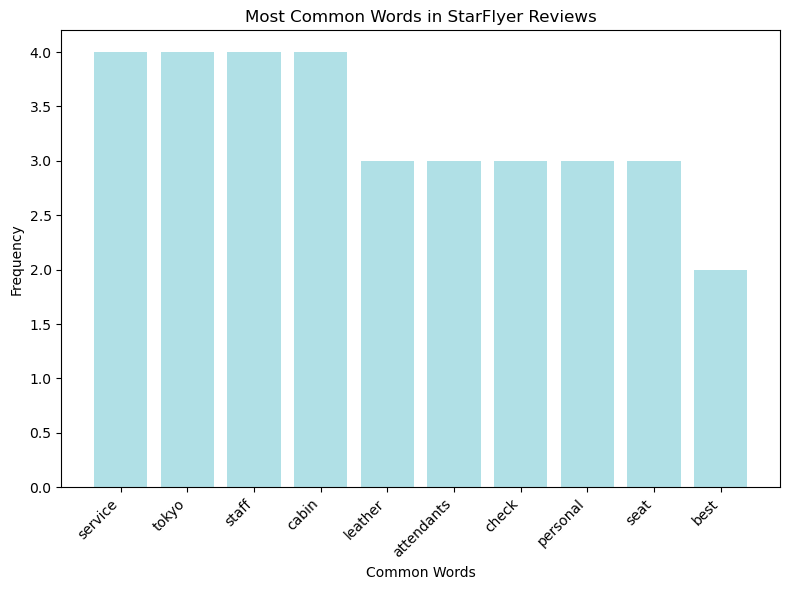

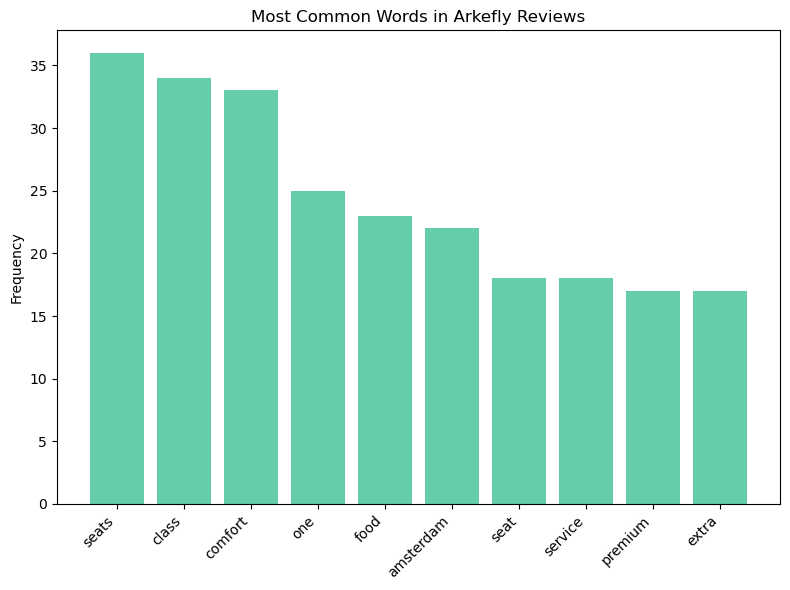

In [219]:
# Filter for StarFlyer and Arkefly reviews
StarFlyer_df = df[df['Airline Name'] == 'StarFlyer']
Arkefly_df = df[df['Airline Name'] == 'Arkefly']

# Define custom stopwords
custom_stopwords = {'i','the','only','t','had','would', 'and', 'is', 'to', 'in', 'it', 'a', 'for', 'of', 'on', 'this', 
                    'that', 'with', 'as', 'at', 'by', 'are', 'was', 'an', 'be', 
                    'have', 'from', 'but', 'not', 'or', 'all', 'can', 'you', 
                    'your', 'my', 'if', 'I', 'me', 'he', 'she', 'we', 'they', 
                    'what', 'there', 'their', 'this', 'its', 'so', 'like', 
                    'no', 'yes', 'do', 'will', 'more', 'than', 'up', 'when', 'flight','starflyer','arkefly','very',
                    'airline','were'}

# Function to extract most common words
def get_common_words(df, num_words=10):
    # Combine all reviews into a single string
    text = ' '.join(df['Review'])
    
    # Remove punctuation and split into words
    words = re.findall(r'\w+', text.lower()) 
    filtered_words = [word for word in words if word not in custom_stopwords]  # Exclude stopwords
    common_words = Counter(filtered_words).most_common(num_words)  # Get the most common words
    return pd.DataFrame(common_words, columns=['Word', 'Frequency'])

# Get common words for both airlines
common_words_starflyer = get_common_words(StarFlyer_df)
common_words_arkefly = get_common_words(Arkefly_df)

# Plot common words for StarFlyer
plt.figure(figsize=(8, 6))
plt.bar(common_words_starflyer['Word'], common_words_starflyer['Frequency'], color='#B0E0E6')
plt.title('Most Common Words in StarFlyer Reviews')
plt.xlabel('Common Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot common words for Arkefly
plt.figure(figsize=(8, 6))
plt.bar(common_words_arkefly['Word'], common_words_arkefly['Frequency'], color='#66CDAA')
plt.title('Most Common Words in Arkefly Reviews')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<p style="font-family: Helvetica, Arial, sans-serif; font-weight: regular; font-size: 16px; color: #003366;"><br/>
Based on the StarFlyer results, common words like “service,” “tokyo,” “staff,” “leather,” “attendants,” “personal,” and “seat” give us a clear idea of why the airline has higher reviews. It shows that passengers are happy with the good service from the staff, the comfort of the leather seats, and that they appreciate the routes to major destinations like Tokyo.
<p style="font-family: Helvetica, Arial, sans-serif; font-weight: regular; font-size: 16px; color: #003366;">
For Arkefly, words like “seats,” “class,” “comfort,” “food,” “amsterdam,” “service,” and “premium” stand out. Since Arkefly has poor ratings, we can assume that passengers are not satisfied with the comfort, food quality, and overall service, especially when it comes to premium offerings. This suggests that Arkefly is not meeting expectations in these key areas.

<p style="font-family: Helvetica, Arial, sans-serif; font-weight: bold; font-size: 16px; color: #003366;"><br/>
How do different seat types fare in terms of ratings?

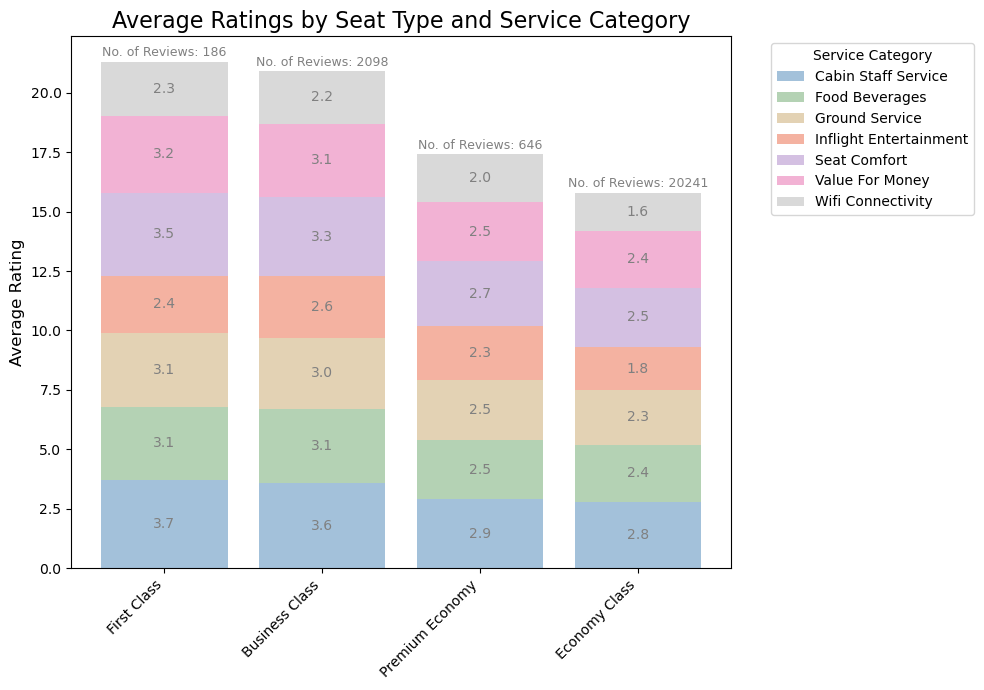

In [220]:
# group data by Seat Type and calculate the mean for each service category rating
avg_ratings_seattype = df.groupby('Seat Type').agg(
    Seat_Comfort=('Seat Comfort', 'mean'),
    Cabin_Staff_Service=('Cabin Staff Service', 'mean'),
    Food_Beverages=('Food & Beverages', 'mean'),
    Ground_Service=('Ground Service', 'mean'),
    Inflight_Entertainment=('Inflight Entertainment', 'mean'),
    Wifi_Connectivity=('Wifi & Connectivity', 'mean'),
    Value_For_Money=('Value For Money', 'mean'),
    Review_Count=('Overall Rating', 'count')  # count number of reviews for each seat type
).reset_index().round(1)

# rename columns to remove underscores
avg_ratings_seattype.rename(columns={
    'Seat_Comfort': 'Seat Comfort',
    'Cabin_Staff_Service': 'Cabin Staff Service',
    'Food_Beverages': 'Food Beverages',
    'Ground_Service': 'Ground Service',
    'Inflight_Entertainment': 'Inflight Entertainment',
    'Wifi_Connectivity': 'Wifi Connectivity',
    'Value_For_Money': 'Value For Money'
}, inplace=True)

# custom sort order for seat types
seat_order = ['First Class', 'Business Class', 'Premium Economy', 'Economy Class']

# reindex avg_ratings_seattype to ensure it matches the seat order
avg_ratings_seattype = avg_ratings_seattype.set_index('Seat Type').reindex(seat_order).reset_index()

# custom color palette
color_palette = [
    '#A3C1DA',  # blue
    '#B4D2B4',  # green
    '#E3D2B4',  # yellow
    '#F4B2A1',  # orange
    '#D4C0E2',  # purple
    '#F2B2D4',  # pink
    '#D9D9D9',  # grey
]

# melt df for stacking
avg_ratings_seattype_melted = avg_ratings_seattype.melt(
    id_vars=['Seat Type', 'Review_Count'], 
    value_vars=['Seat Comfort', 'Cabin Staff Service', 'Food Beverages', 
                'Ground Service', 'Inflight Entertainment', 
                'Wifi Connectivity', 'Value For Money'],
    var_name='Service_Category', 
    value_name='Rating'
)

# pivot table for plotting
pivot_df = avg_ratings_seattype_melted.pivot_table(
    index='Seat Type', 
    columns='Service_Category', 
    values='Rating'
).fillna(0)

# reindex pivot table according to the custom order
pivot_df = pivot_df.reindex(seat_order)

fig, ax = plt.subplots(figsize=(10, 7))

# initialize bottom positions for stacking
bottom = pd.Series([0] * len(pivot_df.index), index=pivot_df.index)

# plot each service category with corresponding color
for idx, (service, color) in enumerate(zip(pivot_df.columns, color_palette)):
    ax.bar(
        pivot_df.index, 
        pivot_df[service], 
        label=service, 
        bottom=bottom, 
        color=color
    )
    bottom += pivot_df[service]  # update bottom position for stacking

    # add average rating annotations for each service category
    for i, value in enumerate(pivot_df[service]):
        ax.text(i, bottom[i] - value / 2, f"{value:.1f}", ha='center', va='center', fontsize=10, color='grey')

# add review count annotations
for i, review_count in enumerate(avg_ratings_seattype['Review_Count']):
    total_height = bottom[i]  # Height at which to place the review count annotation
    ax.text(i, total_height + 0.1, f"No. of Reviews: {review_count}", ha='center', va='bottom', fontsize=9, color='grey')

# add labels and title
ax.set_title('Average Ratings by Seat Type and Service Category', fontsize=16)
ax.set_ylabel('Average Rating', fontsize=12)

# position legend outside plot area
ax.legend(title='Service Category', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<p style="font-family: Helvetica, Arial, sans-serif; font-weight: regular; font-size: 16px; color: #003366;">
The chart shows that first class has the highest average rating, while economy class is rated the lowest. However, economy has the most reviews, likely because it’s the most common seat type. First class, with fewer reviews, caters to a smaller group of travellers.

<p style="font-family: Helvetica, Arial, sans-serif; font-weight: regular; font-size: 16px; color: #003366;">
First class also seems to score the highest for all service category ratings, except for inflight entertainment, which was surpassed by business class. Economy class appears to score the lowest for all service category ratings. The higher volume of reviews for economy class could indicate a greater diversity of experiences, possibly leading to lower average ratings across service categories.

<p style="font-family: Helvetica, Arial, sans-serif; font-weight: bold; font-size: 16px; color: #003366;"><br/>
    What factors influence whether a passenger recommends an airline?

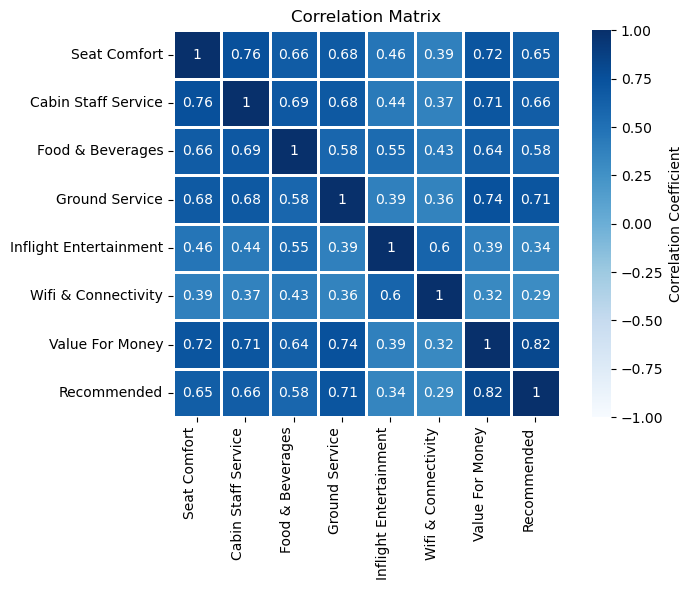

In [221]:
# ensure 'Recommended' column is a string and handle NaN values
df['Recommended'] = df['Recommended'].fillna('').astype(str).str.strip().str.lower()

# convert 'Recommended' to binary format
df['Recommended'] = df['Recommended'].map({'yes': 1, 'no': 0})

# select relevant features
features = ['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 
            'Ground Service', 'Inflight Entertainment', 'Wifi & Connectivity', 
            'Value For Money']

# correlation matrix
corr_matrix = df[features + ['Recommended']].corr()

# plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix, 
    annot=True,  # display correlation coefficients
    cmap='Blues',  # color scale
    vmin=-1, vmax=1,  # range of color scale
    square=True, 
    linewidths=1.0, 
    cbar_kws={'label': 'Correlation Coefficient'},
)

# titles and labels
plt.title('Correlation Matrix')
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

<p style="font-family: Helvetica, Arial, sans-serif; font-weight: regular; font-size: 16px; color: #003366;">
The heatmap results indicate that “Value for Money” and “Ground Service” are the top factors influencing a passenger’s likelihood to recommend an airline.

<p style="font-family: Helvetica, Arial, sans-serif; font-weight: bold; font-size: 16px; color:#003366;"><br/>
    What is the % of verified vs unverified reviews, and how does the verification status affect the ratings?

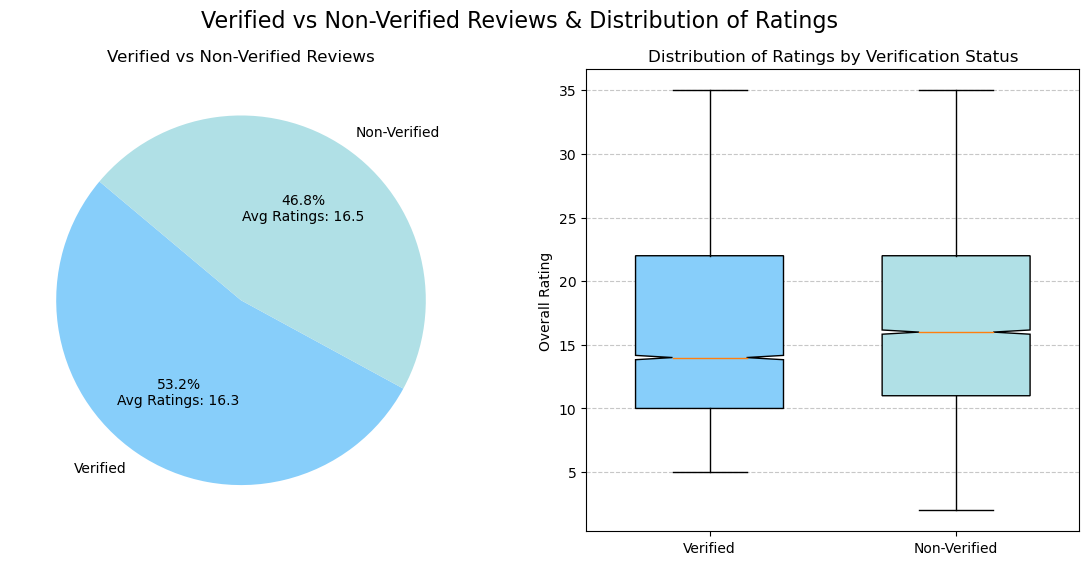

In [222]:
# calculate the total and verified/non-verified reviews
total_reviews = len(df)
verified_reviews = df['Verified'].sum()
non_verified_reviews = total_reviews - verified_reviews

# calculate average overall rating for verified and non-verified reviews
average_rating_verified = df[df['Verified'] == True]['Overall Rating'].mean().round(1)
average_rating_non_verified = df[df['Verified'] == False]['Overall Rating'].mean().round(1)

# date for pie chart
labels = ['Verified', 'Non-Verified']
sizes = [verified_reviews, non_verified_reviews]
avg_ratings = [average_rating_verified, average_rating_non_verified]
colors = ['#87CEFA', '#B0E0E6']

# create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Verified vs Non-Verified Reviews & Distribution of Ratings", fontsize=16)

# pie chart for verified and non-verified reviews
wedges, texts, autotexts = axs[0].pie(
    sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, wedgeprops=dict(width=1)
)

# show % and average rating on the pie chart
for i, a in enumerate(autotexts):
    percent_text = f"{a.get_text()}"  # percentage text
    a.set_text(f"{percent_text}\nAvg Ratings: {avg_ratings[i]}")  # show average ratings

axs[0].set_title("Verified vs Non-Verified Reviews")

# box plot for distribution of ratings by verification status
verified_data = [df[df['Verified'] == status]['Overall Rating'].dropna() for status in [True, False]]
box = axs[1].boxplot(
    verified_data, 
    patch_artist=True, 
    notch=True, 
    vert=True, 
    widths=0.6,
)

# set colors for each box
box['boxes'][0].set_facecolor('#87CEFA')  # Color for Verified
box['boxes'][1].set_facecolor('#B0E0E6')  # Color for Non-Verified

axs[1].set_xticklabels(['Verified', 'Non-Verified'])
axs[1].set_title("Distribution of Ratings by Verification Status")
axs[1].set_ylabel("Overall Rating")
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

<p style="font-family: Helvetica, Arial, sans-serif; font-weight: regular; font-size: 16px; color: #003366;">
From the pie chart, we can observe that verified reviews make up slightly more at 53.2%. However, despite having more verified reviews, the average rating for these is lower by 0.2 compared to non-verified reviews. The box plot shows that the overall distribution of ratings between the two groups is quite similar, though the verified reviews have a lower Q1.
<p style="font-family: Helvetica, Arial, sans-serif; font-weight: regular; font-size: 16px; color: #003366;">
This suggests that while most reviews are verified, the verification process doesn’t necessarily translate into higher ratings, and the range of ratings is still quite comparable.

<p style="font-family: Helvetica, Arial, sans-serif; font-weight: bold; font-size: 16px; color:#003366;"><br/>
Export data to csv, to be used on Tableau

In [223]:
df.to_csv('revised_airline_review.csv', index=False)

<p style="font-family: Helvetica, Arial, sans-serif; font-weight: bold; font-size: 16px;">

<p style="font-family: Helvetica, Arial, sans-serif; font-weight: bold; font-size: 16px;">